In [1]:
# Imports needed.
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

# Get MNIST from tensorflow tutorials.
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

# Set the training parameters
num_steps = 100000 
batch_size = 128  
beta1 = 0.5
lr_generator = 0.0005
lr_discriminator = 0.0005

# Set the network parameters
image_dim = 784              # 28*28 pixels * 1 channel
noise_dim = 128              # Noise data points

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [0]:
# Functions for visualizing the results.

def plot_fun1():
  # Generate images from noise, using the generator network.
  n = 6
  canvas = np.empty((28 * n, 28 * n))
  for i in range(n):
      # Noise input.
      z = np.random.uniform(-1., 1., size=[n, noise_dim])
      # Generate image from noise.
      g = sess.run(z_sample, feed_dict={noise_input: z, is_training:False})
      # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
      g = (g + 1.) / 2.
      for j in range(n):
          # Draw the generated digits
          canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

  plt.figure(figsize=(n, n))
  plt.imshow(canvas, origin="upper", cmap="gray")
  plt.show()
  
  
def plot_fun2():
  n=2
  for i in range(n):
    # Noise input.
    z = np.random.uniform(-1., 1., size=[1, noise_dim])
    # Generate image from noise.
    g = sess.run(z_sample, feed_dict={noise_input: z, is_training:False})
    # Rescale values to the original [0, 1] (from tanh -> [-1, 1])
    g = (g + 1.) / 2.
    plt.figure(figsize=(5, 5))
    plt.imshow(g.reshape([28,28]), origin="upper", cmap="gray")
    plt.show()

In [0]:
# Loss functions based on Algorithm 3

def gen_difs(z, x, batch_size):
  
  fake_difs = tf.expand_dims(z, axis=1) - tf.expand_dims(z, axis=0)
  fake_mask = tf.constant(~np.eye(batch_size, dtype=bool))  
  fake_difs = tf.boolean_mask(fake_difs, fake_mask)
  fake_difs = tf.reshape(fake_difs,  [batch_size, batch_size-1, -1])
  
  fake_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(fake_difs), axis=2, keepdims=True))
 
  real_difs = tf.add(x, -z)
  real_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(real_difs), axis=1, keepdims=True))
  
  dif_mat = tf.expand_dims(real_eucl_dist, axis=1) - tf.expand_dims(fake_eucl_dist, axis=0)
  dif_mat = tf.reshape(dif_mat,  [batch_size, batch_size-1, -1])
  return(dif_mat)

def disc_difs(z, x, batch_size):

  fake_difs = tf.expand_dims(z, axis=0) - tf.expand_dims(z, axis=1)
  fake_mask = tf.constant(~np.eye(batch_size, dtype=bool))  
  fake_difs = tf.boolean_mask(fake_difs, fake_mask)
  fake_difs = tf.reshape(fake_difs,  [batch_size, batch_size-1, -1])
  
  fake_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(fake_difs), axis=2, keepdims=True))
  
  real_difs = tf.add(x, -z)
  real_eucl_dist = tf.sqrt(tf.reduce_sum(tf.square(real_difs), axis=1, keepdims=True))
  
  dif_mat_ = tf.expand_dims(real_eucl_dist, axis=1) - tf.expand_dims(fake_eucl_dist, axis=0)

  dif_mat = tf.reshape(dif_mat_, [batch_size, batch_size-1, -1])
  dif_mat = - tf.minimum(dif_mat, 0.5) #tf.maximum(-dif_mat+1., 0)
  
  return(dif_mat)

In [0]:
# Network Inputs 

noise_input      = tf.placeholder(tf.float32, shape=[None, noise_dim])
real_image_input = tf.placeholder(tf.float32, shape=[None, 784])

# Boolean indicator for training process
is_training = tf.placeholder(tf.bool)

# LeakyReLU activation function
def leakyrelu(x, alpha=0.2):
    return 0.5*x*(1 + alpha) + 0.5*abs(x)*(1 - alpha)

#### Generator Network ####
# Input: Noise  [,128]
# Output: Image [,784]
def generator(x, reuse=False):
    with tf.variable_scope('Generator', reuse=reuse):
        x = tf.layers.dense(x, 256)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 512)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 1024)
        x = tf.layers.batch_normalization(x, training=is_training)
        x = leakyrelu(x)
        # Linear projection to 28*28: (batch, 28, 28, 1)
        x = tf.layers.dense(x, 784)
        x = tf.nn.tanh(x)
    return x
  
#### Discriminator Network ####
# Input: Image      [,784] 
# Output: Embedding [,4]
def discriminator(x, reuse=False):
    with tf.variable_scope('Discriminator', reuse=reuse):
        x = tf.layers.dense(x, 1024)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 512)
        x = leakyrelu(x)
        x = tf.layers.dense(x, 256)
        x = leakyrelu(x)
        # Linear projection to dimension 4
        x = tf.layers.dense(x, 4)
    return x

In [5]:
#### Model setup ####

# Initialize the Networks #

# Generator Network
z_sample = generator(noise_input)
# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(real_image_input)
disc_fake = discriminator(z_sample, reuse=True)


# Initialize Loss functions and Optimizers #

# Discriminator loss:
disc_loss = tf.reduce_mean(disc_difs(disc_fake, disc_real, batch_size))
# Generator loss:
gen_loss = tf.reduce_mean(gen_difs(disc_fake, disc_real, batch_size))                        
# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=lr_generator, beta1=beta1)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=lr_discriminator, beta1=beta1)


# Separate the training processes of our two networks #
gen_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Generator')
disc_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='Discriminator')

gen_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Generator')
with tf.control_dependencies(gen_update_ops):
    train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)

disc_update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='Discriminator')
with tf.control_dependencies(disc_update_ops):
    train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

    

# Initialize Variables #
init = tf.global_variables_initializer()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Step 1: Generator Loss: 6.991513, Discriminator Loss: -0.260245


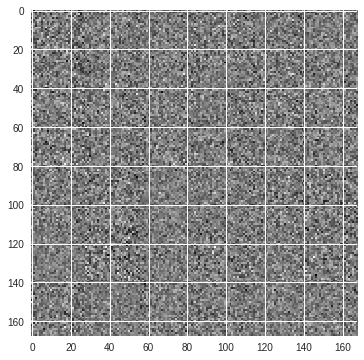

Step 2500: Generator Loss: 0.691238, Discriminator Loss: -0.240120


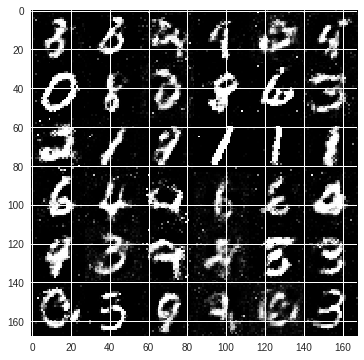

Step 5000: Generator Loss: 0.421984, Discriminator Loss: -0.155796


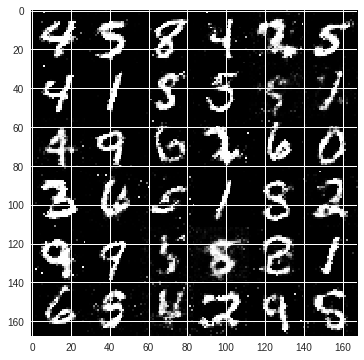

Step 7500: Generator Loss: 0.429283, Discriminator Loss: -0.124553


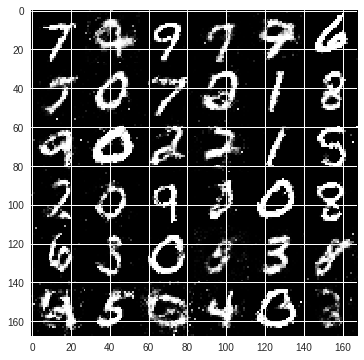

Step 10000: Generator Loss: 0.391309, Discriminator Loss: -0.177207


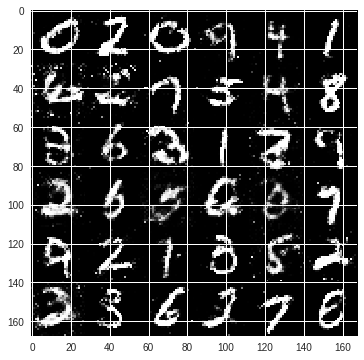

Step 12500: Generator Loss: 0.407981, Discriminator Loss: -0.174071


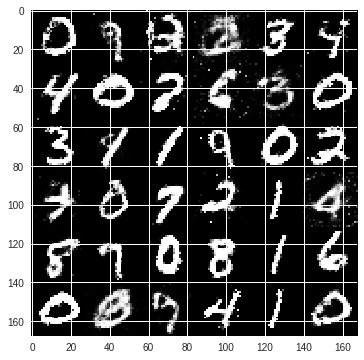

Step 15000: Generator Loss: 0.356697, Discriminator Loss: -0.191771


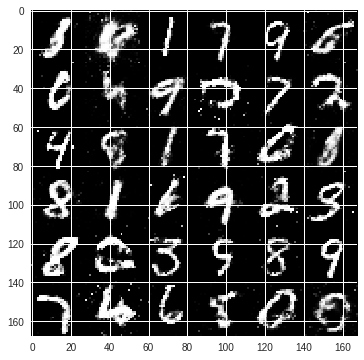

Step 17500: Generator Loss: 0.351202, Discriminator Loss: -0.146124


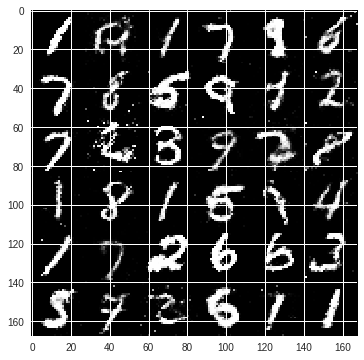

Step 20000: Generator Loss: 0.551827, Discriminator Loss: -0.240266


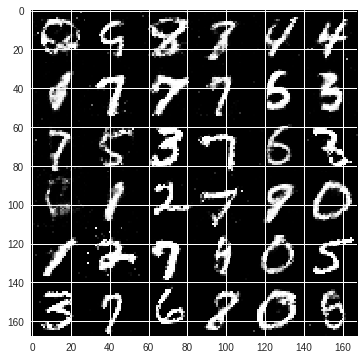

Step 22500: Generator Loss: 0.397368, Discriminator Loss: -0.193707


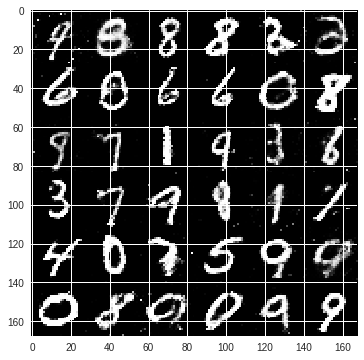

Step 25000: Generator Loss: 0.420725, Discriminator Loss: -0.158678


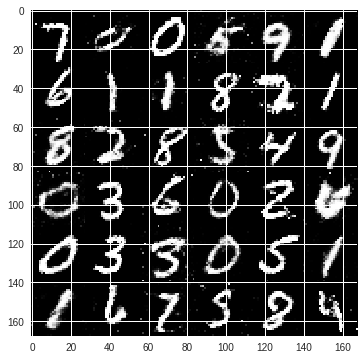

Step 27500: Generator Loss: 0.417631, Discriminator Loss: -0.164398


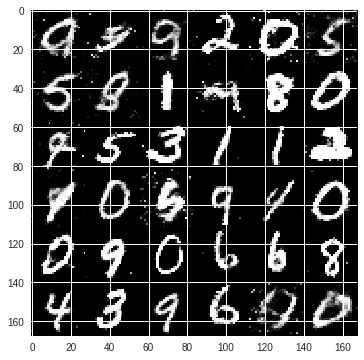

Step 30000: Generator Loss: 0.375192, Discriminator Loss: -0.181723


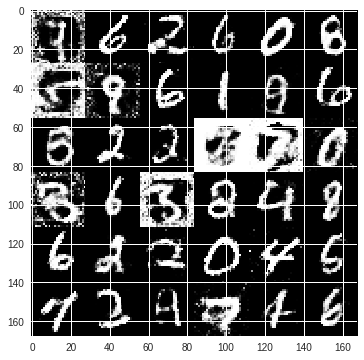

Step 32500: Generator Loss: 0.475010, Discriminator Loss: -0.178089


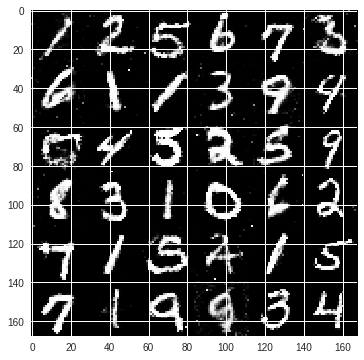

Step 35000: Generator Loss: 0.503507, Discriminator Loss: -0.211120


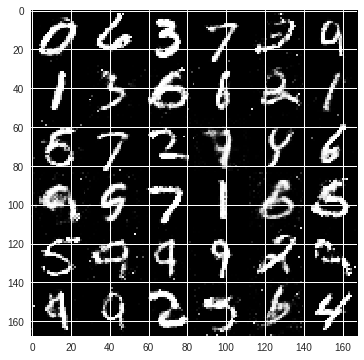

Step 37500: Generator Loss: 0.534477, Discriminator Loss: -0.126369


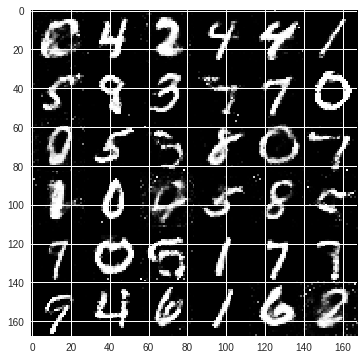

Step 40000: Generator Loss: 0.595391, Discriminator Loss: -0.211748


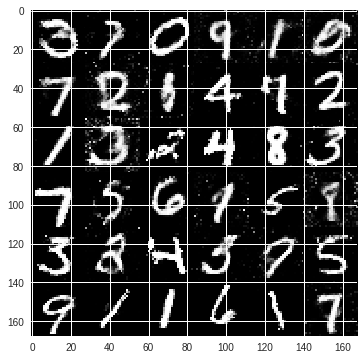

Step 42500: Generator Loss: 0.604822, Discriminator Loss: -0.219067


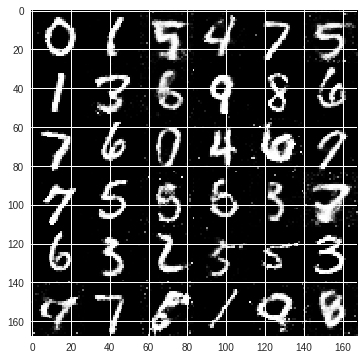

Step 45000: Generator Loss: 0.693423, Discriminator Loss: -0.249714


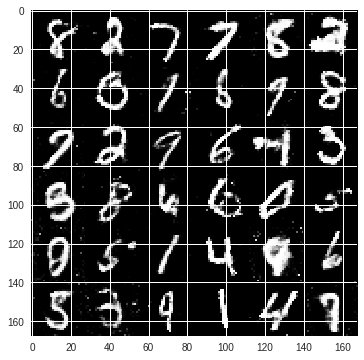

Step 47500: Generator Loss: 0.639525, Discriminator Loss: -0.274934


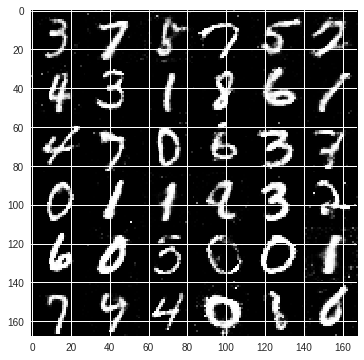

Step 50000: Generator Loss: 0.803947, Discriminator Loss: -0.313723


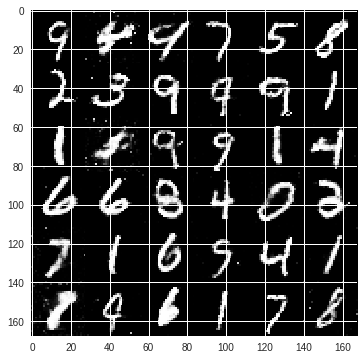

Step 52500: Generator Loss: 0.857433, Discriminator Loss: -0.254283


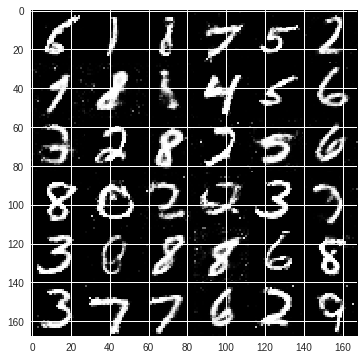

Step 55000: Generator Loss: 0.690804, Discriminator Loss: -0.260292


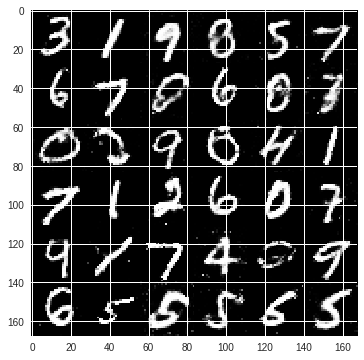

Step 57500: Generator Loss: 1.198054, Discriminator Loss: -0.170428


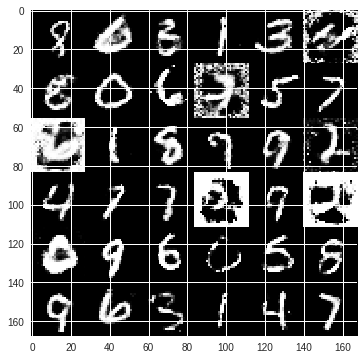

Step 60000: Generator Loss: 0.702794, Discriminator Loss: -0.214872


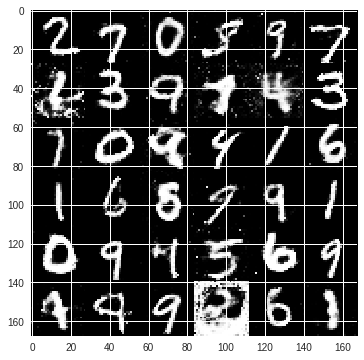

Step 62500: Generator Loss: 0.838150, Discriminator Loss: -0.263320


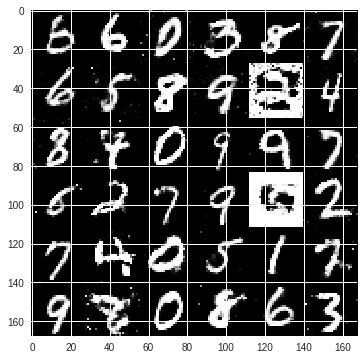

Step 65000: Generator Loss: 0.790839, Discriminator Loss: -0.259100


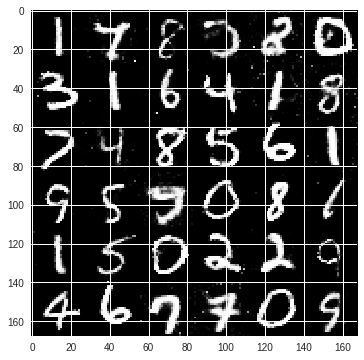

Step 67500: Generator Loss: 0.829971, Discriminator Loss: -0.272620


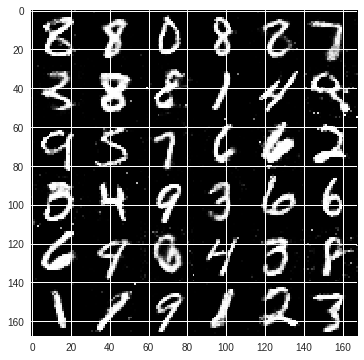

Step 70000: Generator Loss: 0.848480, Discriminator Loss: -0.214052


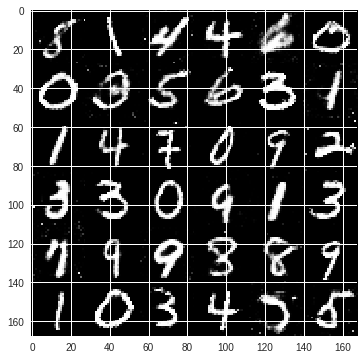

Step 72500: Generator Loss: 0.907669, Discriminator Loss: -0.315375


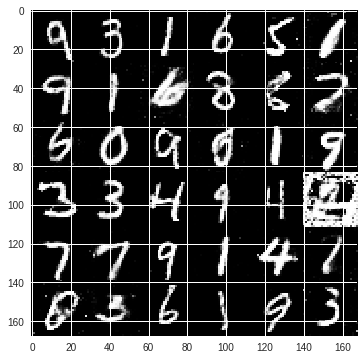

Step 75000: Generator Loss: 0.948563, Discriminator Loss: -0.259414


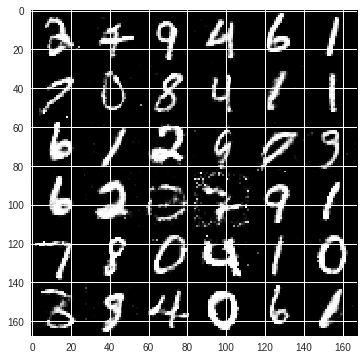

Step 77500: Generator Loss: 1.046006, Discriminator Loss: -0.215536


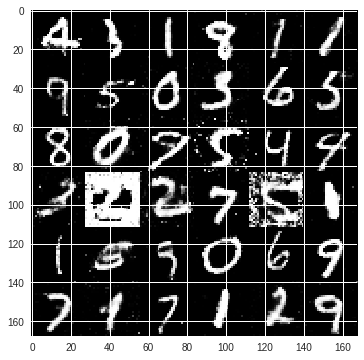

Step 80000: Generator Loss: 1.112574, Discriminator Loss: -0.339940


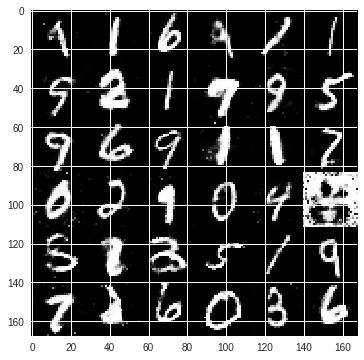

Step 82500: Generator Loss: 0.869718, Discriminator Loss: -0.236932


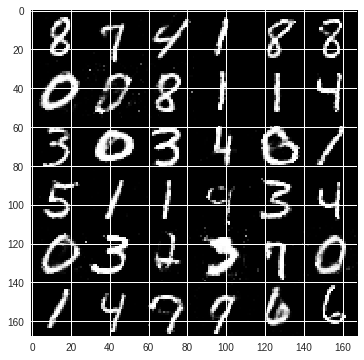

Step 85000: Generator Loss: 1.056530, Discriminator Loss: -0.302777


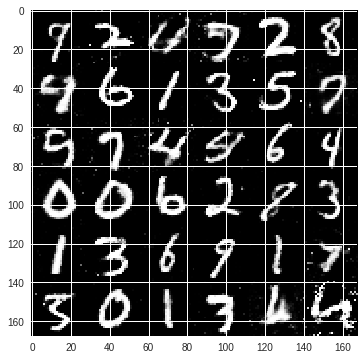

Step 87500: Generator Loss: 1.289460, Discriminator Loss: -0.316854


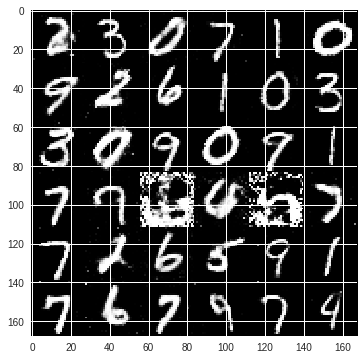

Step 90000: Generator Loss: 0.967580, Discriminator Loss: -0.320431


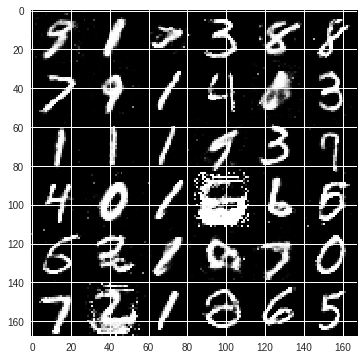

Step 92500: Generator Loss: 1.507549, Discriminator Loss: -0.306404


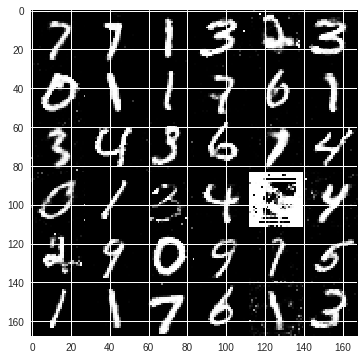

Step 95000: Generator Loss: 1.082504, Discriminator Loss: -0.299523


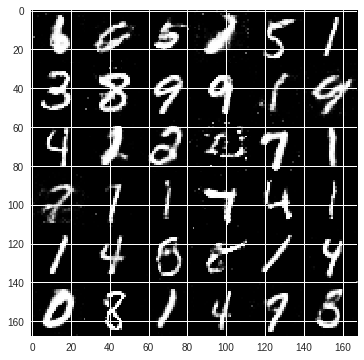

Step 97500: Generator Loss: 0.863068, Discriminator Loss: -0.345658


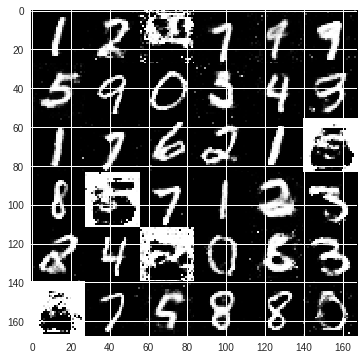

Step 100000: Generator Loss: 0.933272, Discriminator Loss: -0.304877


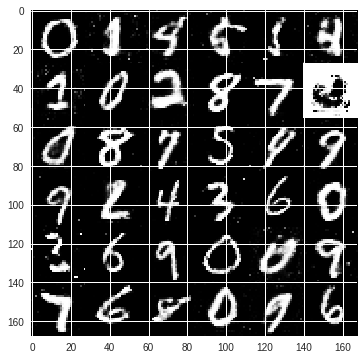

In [6]:
#### Training and Visualization ####

# Start a TF-Session and run the initializer.
sess = tf.Session()
sess.run(init)

# Training
for i in range(1, num_steps+1):

    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    batch_x = np.reshape(batch_x, newshape=[-1, 28, 28, 1])
    batch_x = batch_x.reshape([-1, 28*28])
    # Rescale to [-1, 1], the input range of the discriminator
    batch_x = batch_x * 2. - 1.

    # Discriminator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, dl = sess.run([train_disc, disc_loss], feed_dict={real_image_input: batch_x, noise_input : z, is_training:True})
    
    # Generator Training
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])
    _, gl = sess.run([train_gen, gen_loss], feed_dict={real_image_input: batch_x, noise_input: z, is_training:True})
    
    if i % 2500 == 0 or i == 1:
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        plot_fun1()

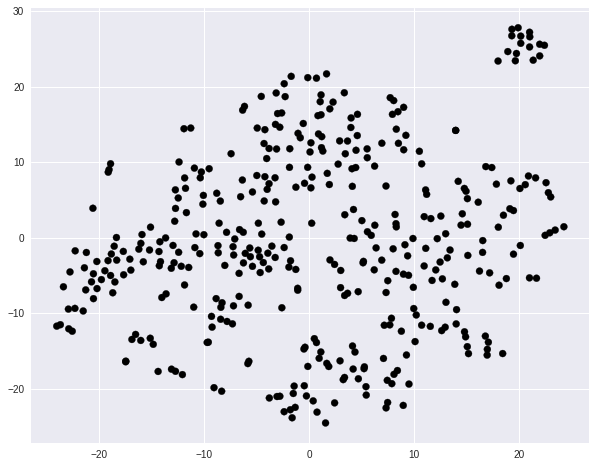

In [7]:
# Import for tSNE visualization
from sklearn.manifold import TSNE

# Number of noise samples
n_sne = 400

# Generate n_sne nois samples and rescale them:
z_sne = np.random.uniform(-1., 1., size=[n_sne, noise_dim])
g_sne = sess.run(z_sample, feed_dict={noise_input: z_sne, is_training:False})
#Rescale values to the original [0, 1] (from tanh -> [-1, 1])
g_sne = (g_sne + 1.) / 2.

# Visualization of the embedded 2-D space of the Generated Images alone.
tsne = TSNE()
tsne_results = tsne.fit_transform(g_sne)

v = ['black']*len(tsne_results)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=v)
plt.show()


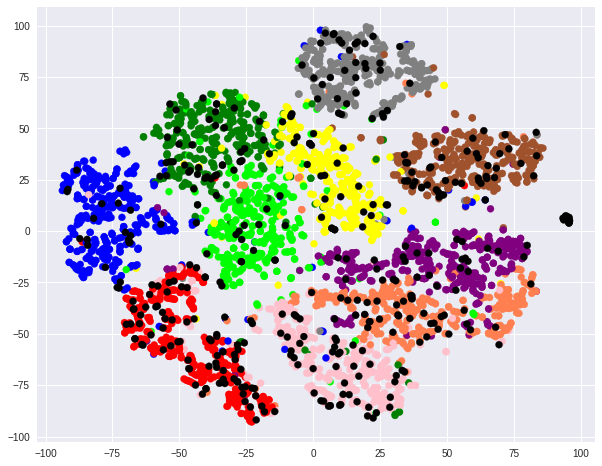

In [8]:
# Load real imges from MNIST (now we consider their labels)
test_x, test_y = mnist.test.next_batch(4000)

# Transform vectorized label into a scalar
v = []
for i in range(len(test_y)):
  v.append(test_y[i].argmax())

# Build an artificial label for the Generated Images
g_lab = [10]*len(g_sne)

# Concatenate both datasets (real_images, labels{0...9}) with (fake images, label{10})
v     = np.asarray(v)
f_v   = np.concatenate([v,g_lab], axis=0)
cdict = {0: 'gray', 1: 'red', 2: 'blue', 3: 'green', 4: 'purple', 5: 'yellow',
         6: 'sienna', 7: 'pink', 8:'lime', 9:'coral', 10:'black'}
f_sne = np.concatenate([ test_x,g_sne], axis=0)

# Visualization of the combined tSNE
tsne = TSNE(perplexity=10)
tsne_results = tsne.fit_transform(f_sne)

plt.figure(figsize=(10, 8))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=np.vectorize(cdict.get)(f_v), label=f_v)
plt.show()

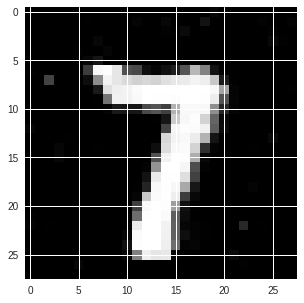

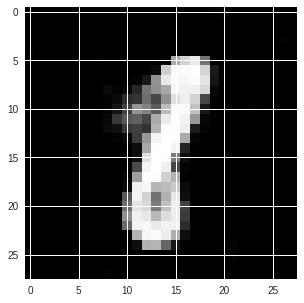

In [9]:
# Image Generator

plot_fun2()